# Small Example of iDLG on CIFAR10

In [252]:
from matplotlib import pyplot as plt 
import skimage 
import numpy as np 
from tqdm import tqdm
import torch as torch
import torch.nn as nn
from torchvision import transforms
from torch.optim.lbfgs import LBFGS
from torch.optim.adam import Adam
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from os import getcwd, listdir
from os.path import join

In [ ]:
class iDLG:
    def __init__(
        self,
        model,
        orig_img,
        label,
        device,
        *,
        seed: int | None = None,
        clamp: tuple[float, float] | None = (0.0, 1.0),
    ) -> None:
        self.device = device if isinstance(device, str) else (device.type if hasattr(device, "type") else "cpu")
        self.model = model.to(self.device)
        self.orig_img = orig_img.to(self.device)
        self.criterion = nn.CrossEntropyLoss(reduction='sum').to(self.device)
        self.label = label.to(self.device)
        self.tt = transforms.ToPILImage()
        self.clamp = clamp
        self.param_dtype = next(self.model.parameters()).dtype
        if self.orig_img.dtype != self.param_dtype:
            self.orig_img = self.orig_img.to(self.param_dtype)
        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

    def _infer_label_from_grads(self, orig_grads):
        named_grads = {name: g for (name, _), g in zip(self.model.named_parameters(), orig_grads)}
        last_bias_name = None
        for name, param in self.model.named_parameters():
            if name.endswith(".bias") and param.ndim == 1:
                last_bias_name = name
        bias_grad = named_grads[last_bias_name]
        return torch.argmin(bias_grad).detach().reshape((1,))

    def attack(self, iterations=200, use_adam=False):
        self.model.eval()
        predicted = self.model(self.orig_img)
        loss = self.criterion(predicted, self.label)
        orig_grads = torch.autograd.grad(loss, self.model.parameters())
        orig_grads = list((_.detach().clone() for _ in orig_grads))
        dummy_data = (torch.randn(self.orig_img.size(), dtype=self.param_dtype, device=self.device).requires_grad_(True))
        label_pred = self._infer_label_from_grads(orig_grads).requires_grad_(False)
        if use_adam:
            optimizer = Adam([dummy_data], lr=0.1)
        else:
            optimizer = LBFGS([dummy_data], lr=0.1, max_iter=50, tolerance_grad=1e-09, tolerance_change=1e-11, history_size=100, line_search_fn='strong_wolfe')
        history = []
        losses = []

        for iters in tqdm(range(iterations)):
            dummy_data_prev = dummy_data.clone().detach()
            def closure():
                optimizer.zero_grad()
                dummy_pred = self.model(dummy_data)
                dummy_loss = self.criterion(dummy_pred, label_pred)
                dummy_dy_dx = torch.autograd.grad(dummy_loss, self.model.parameters(), create_graph=True)
                grad_diff = 0
                for gx, gy in zip(dummy_dy_dx, orig_grads):
                    grad_diff += ((gx - gy) ** 2).sum()
                grad_diff.backward()
                return grad_diff

            if use_adam:
                optimizer.zero_grad()
                grad_diff = closure()
                optimizer.step()
            else:
                optimizer.step(closure)

            if self.clamp is not None:
                with torch.no_grad():
                    dummy_data.clamp_(self.clamp[0], self.clamp[1])

            if iters % 1 == 0:
                current_loss = closure()
                losses.append(current_loss.item())
                history.append(self.tt(dummy_data[0].cpu()))

        return dummy_data.detach().numpy().squeeze(), label_pred, history, losses

### Define Model Architecture 

In [254]:
# 1 x (conv + activation) -> linear to num_classes
class LeNetSimple1sig(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple1sig, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.rand(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.rand(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

# Relu
class LeNetSimple1Relu(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple1Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.rand(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.rand(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

In [255]:
# 2 x (conv + activation) -> linear to num_classes
class LeNetSimple2sig(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple2sig, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

# Relu
class LeNetSimple2Relu(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple2Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

In [256]:
# 3 x conv + activation -> linear to num_classes
class LeNetSimple3sig(nn.Module):
    def __init__(self, channel: int = 3, hidden:int = 768, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple3sig, self).__init__()
        act = nn.Sigmoid
        self.layer1 = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),)
        self.layer2 = nn.Sequential(nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),)
        self.layer3 = nn.Sequential(nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),)
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(x)
        out = self.layer3(x)
        out = self.flatten(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

# Relu
class LeNetSimple3Relu(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple3Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

model = LeNetSimple3sig()
model.layer_summary((1, 3, 32, 32))

Input shape: torch.Size([1, 3, 32, 32])
layer1 (Sequential) output shape:	 torch.Size([1, 12, 16, 16])
layer2 (Sequential) output shape:	 torch.Size([1, 12, 8, 8])
layer3 (Sequential) output shape:	 torch.Size([1, 12, 8, 8])
flatten (Flatten) output shape:	 torch.Size([1, 768])
fc (Sequential) output shape:	 torch.Size([1, 10])


In [257]:
# 3 x conv + activation +  -> linear 768 to 10

# Sigmoid
class LeNet3sigAvg(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNet3sigAvg, self).__init__()
        act = nn.Sigmoid
        pool = nn.AvgPool2d(kernel_size=5, padding=5//2, stride=1)
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            pool,
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            pool,
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            pool,
            act(),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)
# Relu
class LeNetSimple3Relu(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNetSimple3Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = LeNet3sigAvg()
model.layer_summary((1, 3, 32, 32))

Input shape: torch.Size([1, 3, 32, 32])
body (Sequential) output shape:	 torch.Size([1, 768])
Flattened shape: torch.Size([1, 768])
fc (Sequential) output shape:	 torch.Size([1, 10])


In [258]:
class LeNet(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)

class LeNet5(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10):
        super(LeNet5, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(channel, 6, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
        )

        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.Sigmoid()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, 1)  # becomes (N, 120)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)


### Initialize Model

In [259]:
from sklearn.model_selection import train_test_split
def get_images_from_folders(base_dir, label_folders, image_count):
    x = []
    y = []
    for label_idx, folder in enumerate(label_folders):
        folder_path = join(base_dir, folder)
        all_files = [f for f in listdir(folder_path) if f.endswith('.JPEG')]
        all_files.sort()
        selected_files = all_files[:image_count]
        x.extend([join(folder_path, fname) for fname in selected_files])
        y.extend([label_idx] * len(selected_files))
    return x, y

data_path = "/dtu/datasets1/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/"
label_folders = ["n01440764", "n01775062",  "n02086079",  "n02106030",  "n02190166",  "n02504013",  "n02906734",  "n03223299",  "n03627232",  "n03873416"]

# Example usage:
base_dir = data_path  # or set to your ImageNet subset root
image_count = 50  # number of images per class
x_all, y_all = get_images_from_folders(base_dir, label_folders, image_count)

# Split into train/test (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

print(f"Train: {len(x_train)} images, Test: {len(x_test)} images")
print(f"First train image: {x_train[0]}, label: {y_train[0]}")

Train: 400 images, Test: 100 images
First train image: /dtu/datasets1/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n01775062/n01775062_1039.JPEG, label: 1


In [260]:
# Custom dataset for image paths and labels
class ImagePathDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [264]:
# Define relevant variables for the ML task using custom ImageNet subset
batch_size = 1
num_classes = 10
learning_rate = 0.1
num_epochs = 10
modeltype = LeNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = getcwd()

# Specify the desired image size (resolution)
img_size = (32, 32)  # (width, height)
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
 ])

# Use x_train, y_train, x_test, y_test from previous cell
trainset = ImagePathDataset(x_train, y_train, transform=transform)
testset = ImagePathDataset(x_test, y_test, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

model = modeltype().to(device)
cost = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=learning_rate)

total_step = len(trainset)

save_dir = join(path, "reconstructions")
model.train()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 400 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch+1, num_epochs, i+1, len(trainloader), loss.item()))
    if epoch == (num_epochs-1):
        torch.save(model.state_dict(), f"grads_{modeltype.__name__}_.pt")

Epoch [1/10], Step [400/400], Loss: 11.1851
Epoch [2/10], Step [400/400], Loss: 11.0341
Epoch [3/10], Step [400/400], Loss: 5.9287
Epoch [4/10], Step [400/400], Loss: 51.8437
Epoch [5/10], Step [400/400], Loss: 40.5257
Epoch [6/10], Step [400/400], Loss: 0.9116
Epoch [7/10], Step [400/400], Loss: 1.9271
Epoch [8/10], Step [400/400], Loss: 17.2172
Epoch [9/10], Step [400/400], Loss: 12.9870
Epoch [10/10], Step [400/400], Loss: 35.2319


In [265]:
model = LeNet(num_classes=10)
checkpoint = torch.load(f"grads_{modeltype.__name__}_.pt", map_location="cpu", weights_only=False)
print(type(checkpoint))
if isinstance(checkpoint, dict):
    print(checkpoint.keys())
model.load_state_dict(checkpoint if isinstance(checkpoint, dict) and all(isinstance(v, torch.Tensor) for v in checkpoint.values()) else checkpoint.get('model', checkpoint))
model.eval()

<class 'collections.OrderedDict'>
odict_keys(['body.0.weight', 'body.0.bias', 'body.2.weight', 'body.2.bias', 'body.4.weight', 'body.4.bias', 'fc.0.weight', 'fc.0.bias'])


LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=10, bias=True)
  )
)

### Get a Datapoint 

In [266]:
# Load the first image from the first folder in your dataset
first_image_path = x_all[0]
img = Image.open(first_image_path).convert('RGB')
img_tensor = transform(img)  # transform returns a tensor of shape (C, H, W)
input_image = img_tensor.unsqueeze(0)  # Add batch dimension: (1, C, H, W)
label = torch.tensor([y_all[0]]).long()

### Attack 

[DEBUG] Model training mode: False
[DEBUG] Norms of original grads:
  Param 0: 0.000000
  Param 1: 0.000000
  Param 2: 0.000000
  Param 3: 0.000000
  Param 4: 0.000000
  Param 5: 0.000000
  Param 6: 0.000000
  Param 7: 0.000000
[DEBUG] True label: 0, Inferred label: 0
[DEBUG] dummy_data initial mean: 0.0028, std: 0.9953, requires_grad: True, is_leaf: True


  0%|          | 0/1000 [00:00<?, ?it/s]

[DEBUG] Iter 0: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


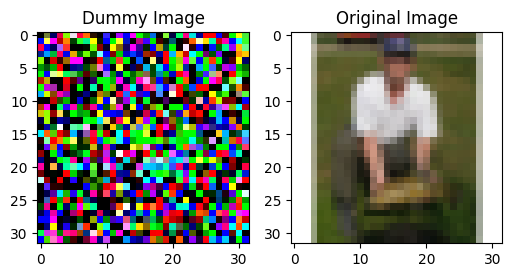

[DEBUG] Iter 0: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


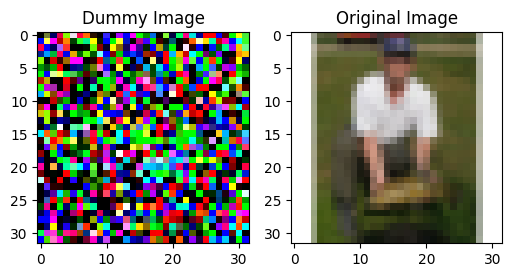

  0%|          | 1/1000 [00:00<04:10,  3.99it/s]

[DEBUG] Iter 0: dummy_data mean: 0.3178, std: 0.3958
[DEBUG] Iter 1: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


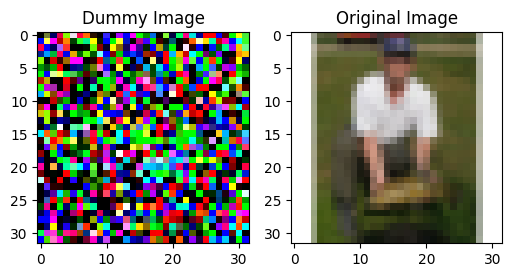

[DEBUG] Iter 1: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


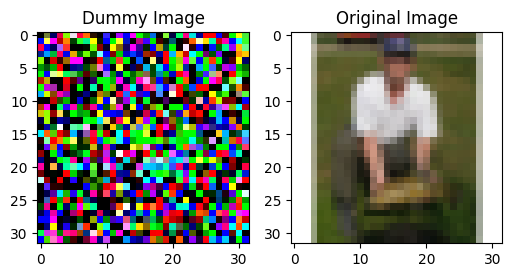

  0%|          | 2/1000 [00:00<04:08,  4.02it/s]

[DEBUG] Iter 1: dummy_data mean: 0.3178, std: 0.3958
[DEBUG] Iter 2: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


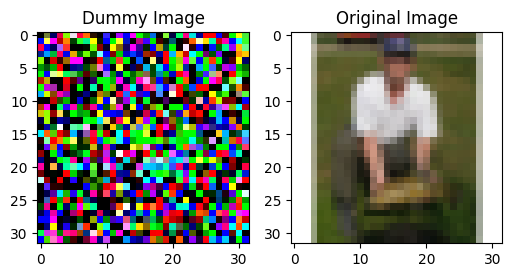

[DEBUG] Iter 2: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


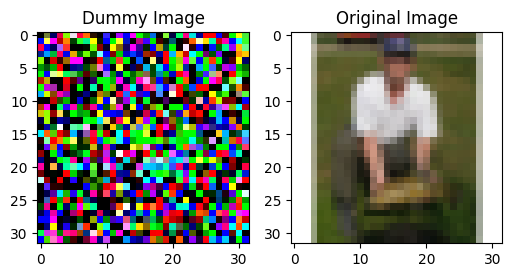

  0%|          | 3/1000 [00:00<04:07,  4.03it/s]

[DEBUG] Iter 2: dummy_data mean: 0.3178, std: 0.3958
[DEBUG] Iter 3: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


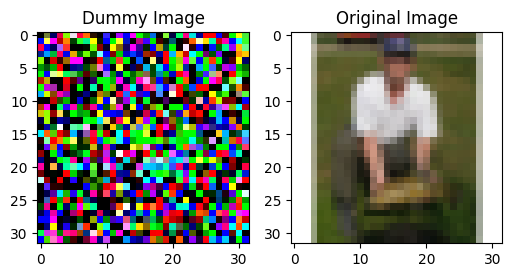

[DEBUG] Iter 3: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


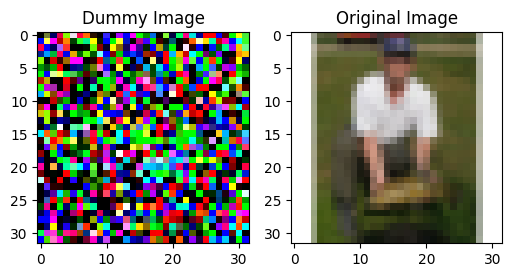

  0%|          | 4/1000 [00:00<04:06,  4.04it/s]

[DEBUG] Iter 3: dummy_data mean: 0.3178, std: 0.3958
[DEBUG] Iter 4: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


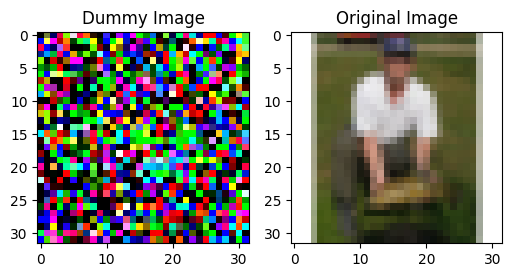

[DEBUG] Iter 4: grad_diff=0.000000, dummy_data.grad norm=0.0
    dummy_dy_dx[0] norm: 0.000000
    dummy_dy_dx[1] norm: 0.000000
    dummy_dy_dx[2] norm: 0.000000
    dummy_dy_dx[3] norm: 0.000000
    dummy_dy_dx[4] norm: 0.000000
    dummy_dy_dx[5] norm: 0.000000
    dummy_dy_dx[6] norm: 0.000000
    dummy_dy_dx[7] norm: 0.000000


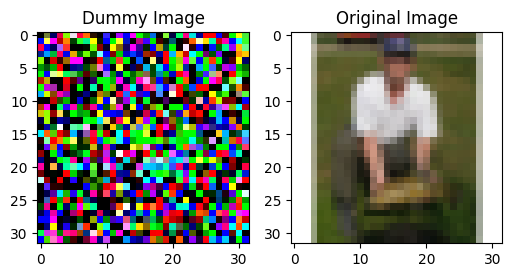

  0%|          | 5/1000 [00:01<04:06,  4.03it/s]

[DEBUG] Iter 4: dummy_data mean: 0.3178, std: 0.3958


100%|██████████| 1000/1000 [00:07<00:00, 135.53it/s]


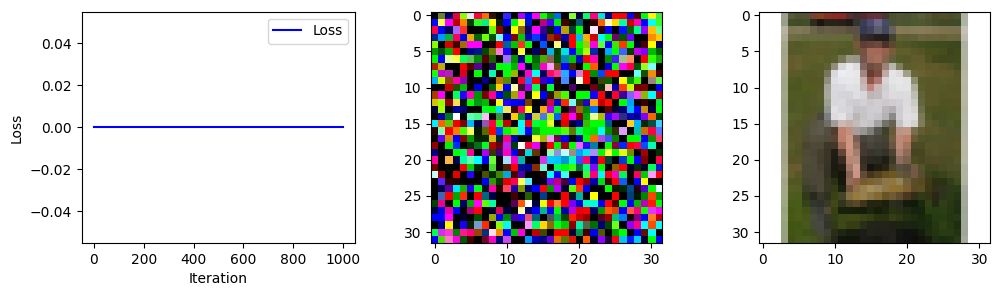

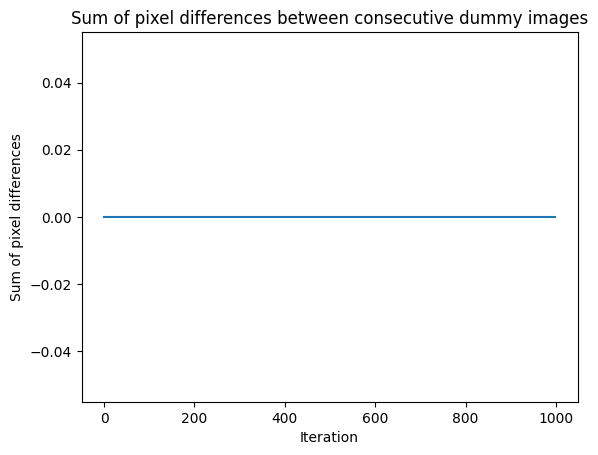

In [268]:
idlg = iDLG(model=model, device=torch.device("cpu"), orig_img = input_image, label = torch.tensor([label.item()]), clamp = (0, 1))
dummy_data_idlg, label_pred_idlg, history_idlg, losses_idlg = idlg.attack(iterations=1000)

fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].plot(losses_idlg, 'b-', label = 'Loss')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].imshow(np.transpose(dummy_data_idlg, (1, 2, 0)))
# Show the original input image correctly
ax[2].imshow(np.transpose(input_image.squeeze().numpy(), (1, 2, 0)))
# ax[1].imshow(history_invgra[34])
plt.show()

diff = [(np.array(history_idlg[i+1]) - np.array(history_idlg[i])).sum().item() for i in range(len(history_idlg)-1)]
plt.plot(diff)
plt.title('Sum of pixel differences between consecutive dummy images')
plt.xlabel('Iteration')
plt.ylabel('Sum of pixel differences')
plt.show()